In [6]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from google.colab import drive  # Import for Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
dataset_path = "/content/drive/MyDrive/coil-20-proc"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load the CUOIL dataset
def load_coil_dataset(dataset_path):
    import cv2
    images = []
    for file in os.listdir(dataset_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            img = cv2.imread(os.path.join(dataset_path, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Resize to (128, 128)
            images.append(img)
    images = np.array(images).astype('float32') / 255.0  # Normalize to [0, 1]
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    return images

# Load images
images = load_coil_dataset(dataset_path)

In [8]:
# Split into train and test sets
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0771 - val_loss: 0.0269
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0213 - val_loss: 0.0102
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

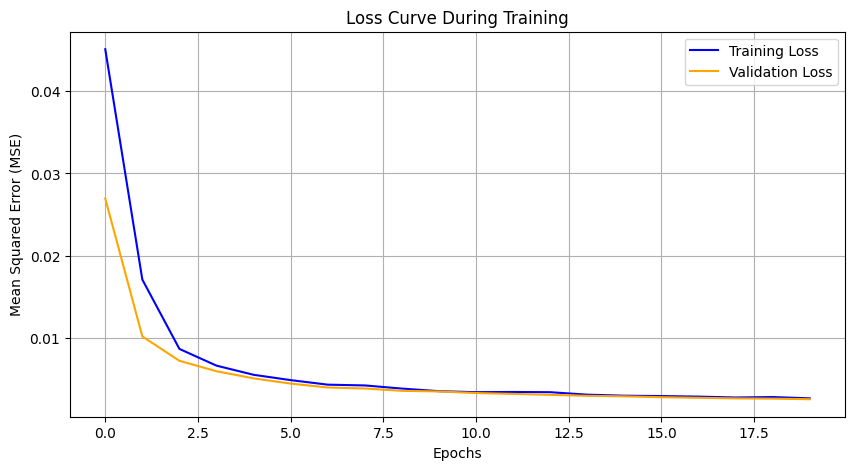

Test MSE Loss: 0.002541982103139162


In [17]:
# Define the CNN Autoencoder architecture
def build_cnn_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Build the model
autoencoder = build_cnn_autoencoder((128, 128, 1))
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, X_test),
    shuffle=True
)

# Evaluate the model
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final test MSE Loss: {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


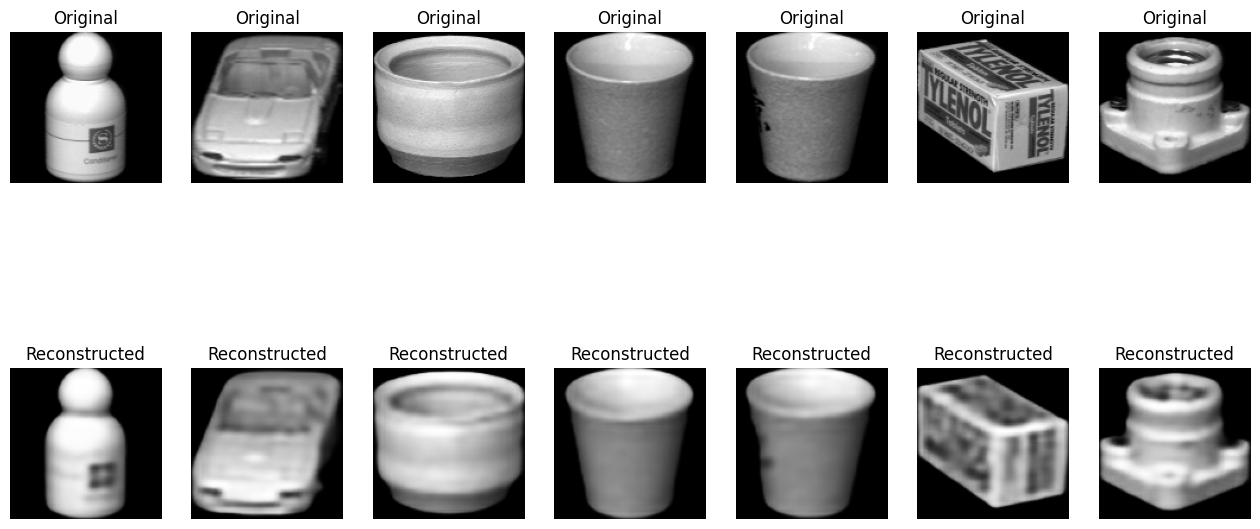

In [16]:
# Visualize some results
def visualize_reconstruction(model, X_test, num_images=7):
    decoded_imgs = model.predict(X_test[:num_images])
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        # Original Image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed Image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

visualize_reconstruction(autoencoder, X_test)

# **Report: CNN Autoencoder for Image Reconstruction**

---

## **1. Architecture of the CNN Autoencoder**

The autoencoder consists of two main components: an **Encoder** and a **Decoder**.

### **Encoder**
- **Input Shape**: `(128, 128, 1)`
- **Layers**:
  - `Conv2D`: 32 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `MaxPooling2D`: pool size `(2, 2)`, padding `same`
  - `Conv2D`: 64 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `MaxPooling2D`: pool size `(2, 2)`, padding `same`
  - `Conv2D`: 128 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `MaxPooling2D`: pool size `(2, 2)`, padding `same`
- **Latent Representation**: Encodes the image into a lower-dimensional space.

### **Decoder**
- **Layers**:
  - `Conv2DTranspose`: 128 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `UpSampling2D`: size `(2, 2)`
  - `Conv2DTranspose`: 64 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `UpSampling2D`: size `(2, 2)`
  - `Conv2DTranspose`: 32 filters, kernel size `(3, 3)`, activation `ReLU`, padding `same`
  - `UpSampling2D`: size `(2, 2)`
  - `Conv2DTranspose`: 1 filter, kernel size `(3, 3)`, activation `sigmoid`, padding `same`
- **Output**: Reconstructs the original image from the latent space.

---


